<a href="https://colab.research.google.com/github/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/blob/master/Klasifikasi%203%20Jenis%20Beras%20Tumpukan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Jenis Beras

# **Mengambil Dataset dari Github**

In [0]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/data > /dev/null
#!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/utils > /dev/null
#!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/Klasifikasi Beras Tumpukan.ipynb > /dev/null

## Persiapan

Program ini dibuat untuk membedakan 3 jenis beras yaitu :

1.   Jenis Beras IR 64
2.   Jenis Beras Cilamaya
3.   Jenis Beras Ketan

Pada program ini menggunakan metode Convolutional Neural Network (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi Library

In [0]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

## Mengimpor Dataset

In [5]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data/image
!ls data/image/train
!ls data/image/train/Cilamaya
!ls data/image/train/IR64
!ls data/image/train/Ketan

test  test.txt	train  train.txt
Cilamaya  IR64	Ketan
C10.jpg  C13.jpg  C16.jpg  C19.jpg  C21.jpg  C24.jpg  C3.jpg  C6.jpg  C9.jpg
C11.jpg  C14.jpg  C17.jpg  C1.jpg   C22.jpg  C25.jpg  C4.jpg  C7.jpg
C12.jpg  C15.jpg  C18.jpg  C20.jpg  C23.jpg  C2.jpg   C5.jpg  C8.jpg
I10.jpg  I13.jpg  I16.jpg  I19.jpg  I21.jpg  I24.jpg  I3.jpg  I6.jpg  I9.jpg
I11.jpg  I14.jpg  I17.jpg  I1.jpg   I22.jpg  I25.jpg  I4.jpg  I7.jpg
I12.jpg  I15.jpg  I18.jpg  I20.jpg  I23.jpg  I2.jpg   I5.jpg  I8.jpg
K10.jpg  K13.jpg  K16.jpg  K19.jpg  K21.jpg  K24.jpg  K3.jpg  K6.jpg  K9.jpg
K11.jpg  K14.jpg  K17.jpg  K1.jpg   K22.jpg  K25.jpg  K4.jpg  K7.jpg
K12.jpg  K15.jpg  K18.jpg  K20.jpg  K23.jpg  K2.jpg   K5.jpg  K8.jpg


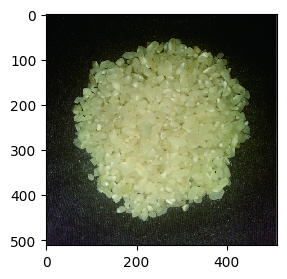

In [6]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/image/train/Cilamaya/C17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [7]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
X_train = []
y_train = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/train",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_train.append(image)
        category = os.path.split(folder)[-1]
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Bentuk array dari dataset train (pelatihan) adalah:", X_train.shape,y_train.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (75, 224, 224, 3) (75,)
Bentuk array dari dataset test (pengujian) adalah: (15, 224, 224, 3) (15,)


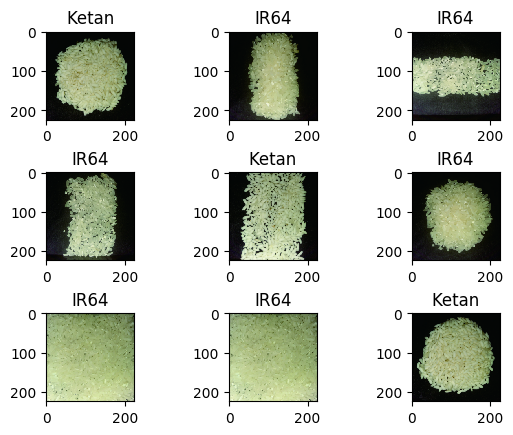

In [8]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#Menampilkan beberapa gambar dari dataset pelatihan secara acak
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "Cilamaya"
    elif y_train[idx] == 1:
        label = "IR64"
    else:
        label = "Ketan"
    plt.title(label)
    plt.imshow(X_train[idx])

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan Deep learning (Convolutional Neural Network)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [9]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Mempersiapkan Data Masukkan

In [0]:
y_train2 = to_categorical(y_train)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train, y_train2, train_size=70, random_state=42)
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model

In [152]:
model = Sequential([
    layers.Conv2D(16, (3,3), input_shape=(224,224,3),name="conv1"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool1",padding="same"),
    #layers.Dropout(0.25),
    layers.Conv2D(32, (3,3),name="conv2"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2",padding="same"),
    #layers.Dropout(0.25),
    #layers.Conv2D(224, (3,3),name="conv3"),
    #layers.Activation("relu"),
    #layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.25),
    #layers.Conv2D(512, (3,3),name="conv4"),
    #layers.Activation("relu"),
    #layers.MaxPool2D((2,2),name="pool4"),
    #layers.Dropout(0.25),
    #layers.Conv2D(512, (3,3),name="conv5"),
    #layers.Activation("relu"),
    #layers.MaxPool2D((2,2),name="pool5"),
    #layers.Dropout(0.25),
    layers.Flatten(),
    #layers.Dense(64,name="fc1"),
    #layers.Activation("relu"),
    layers.Dense(3,name="fc"),
    layers.Activation("softmax")
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 222, 222, 16)      448       
_________________________________________________________________
activation_43 (Activation)   (None, 222, 222, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 111, 111, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 109, 109, 32)      4640      
_________________________________________________________________
activation_44 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 96800)           

## Pelatihan

In [153]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(x = X_train3, y = y_train3, batch_size=70, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Train on 70 samples, validate on 5 samples
Epoch 1/100
70/70 [==============================] - 1s 16ms/step - loss: 1.1038 - acc: 0.3429 - val_loss: 1.8538 - val_acc: 0.2000

Epoch 00001: val_loss improved from inf to 1.85378, saving model to Klasifikasi Beras Tumpukan.h5
Epoch 2/100
70/70 [==============================] - 0s 1ms/step - loss: 2.4804 - acc: 0.3429 - val_loss: 1.2665 - val_acc: 0.6000

Epoch 00002: val_loss improved from 1.85378 to 1.26652, saving model to Klasifikasi Beras Tumpukan.h5
Epoch 3/100
70/70 [==============================] - 0s 1ms/step - loss: 2.8615 - acc: 0.3143 - val_loss: 1.6830 - val_acc: 0.2000

Epoch 00003: val_loss did not improve from 1.26652
Epoch 4/100
70/70 [==============================] - 0s 1ms/step - loss: 1.6545 - acc: 0.3429 - val_loss: 2.4549 - val_acc: 0.2000

Epoch 00004: val_loss did not improve from 1.26652
Epoch 5/100
70/70 [==============================] - 0s 1ms/step - loss: 1.8116 - acc: 0.3429 - val_loss: 1.9745 - val_acc: 0.

## Menggambarkan Hasil Pelatihan

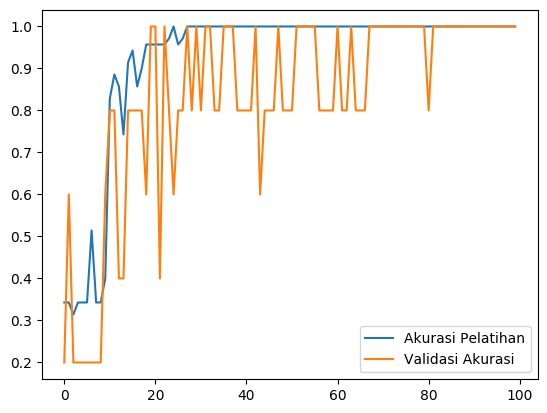

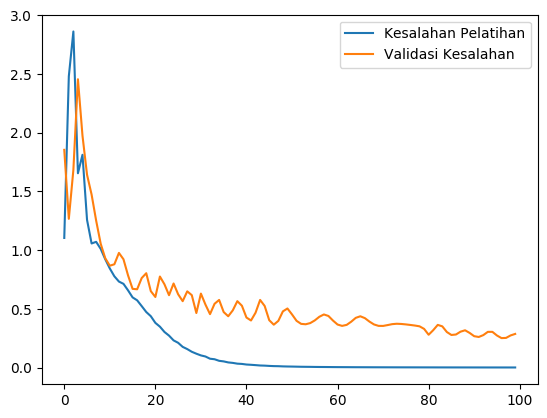

In [154]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

## Menggunakan Model

In [155]:
print(X_train3.shape)

(70, 224, 224, 3)


In [161]:
n = 69
input_image = X_train3[n][np.newaxis,...]
print("Labelnya adalah: ", y_train3[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 0. 1.]
Prediksinya adalah [7.0479306e-05 5.8661669e-04 9.9934286e-01]


Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Cilamaya, IR 64, dan Ketan. Menggunakan inputan gambar dengan piksel 224 x 224, 2 filter (hidden layer) dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

## Evaluasi

In [0]:
#Memuat file bobot model keras ".h5" dengan paling sedikit data validasi yang hilang/error
#File ini akan dikonversi ke tensorflow lite
model.load_weights("Klasifikasi Beras Tumpukan.h5")

In [163]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(x= X_train3, y = y_train3))
#Evaluasi validasi data
print(model.evaluate(x= X_valid3, y = y_valid3))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
70/70 [==============================] - 0s 778us/step
[0.0009745547880551645, 1.0]
5/5 [==============================] - 0s 1ms/step
[0.25100499391555786, 1.0]
15/15 [==============================] - 0s 835us/step
[0.27622190117836, 0.9333333373069763]


In [164]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
[0 0 0 0 0 1 1 1 1 2 2 2 2 2 2]


## Prediksi Gambar Individual

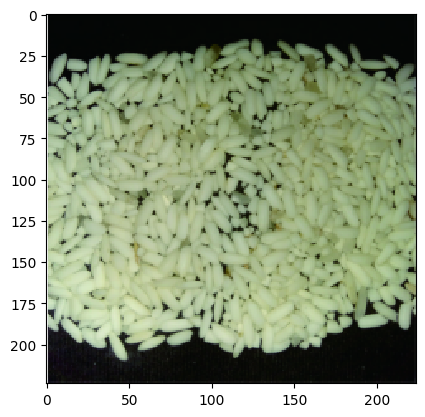

Label yang benar adalah: 2 : Ketan
Nilai yang diprediksi adalah: [0.00598637 0.01464026 0.97937334]
Label yang diprediksi adalah: 2 : Ketan
Prediksi benar


In [165]:
n = 14 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")